# MIDAS Hiring Task Submission - Anirudh Ambati

## Part 1 - Reddit data Collection

The following script is to collect data from /india subreddit of reddit.

Procedure:
praw module is used to collect data. 
Subreddit - /india
Data from the following flares is collected - AskIndia, Non-Political, Reddiquette, scheduled, Photography, Science/Technology, Politics, Business/Finance, Sports, Food, AMA
From each post, the following details are collected - flair, title, url, body, comments


Here, flair can be used as the label to be detected, title, url, body, comments can be used as features to the flair detector. other data like score, id, comms_num, created, author have no relevance for the flaire detection application, so are not significant, but are collected for coding purposes

In each flair, 100 posts are taken. More posts collected means, more training data and can improve the accuracy of the model further. Number of samples colected is limited here to this number as this sample can give reasonable accuracy taking the training time taken.


### Importing the requied modules

In [ ]:
import os
import re
import praw
import logging
import numpy as np
import pandas as pd
import datetime as dt
from numpy import random

import nltk
nltk.download('all')

from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

### Declaring variables

This modules declares the flairs taken in data, replacing/removing punctuations, symbols and numbers and loads the stopwords

In [8]:
flairs = ["AskIndia", 
          "Non-Political", 
          "[R]eddiquette", 
          "Scheduled", 
          "Photography", 
          "Science/Technology", 
          "Politics", 
          "Business/Finance", 
          "Policy/Economy", 
          "Sports", 
          "Food", 
          "AMA"]

REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))

### A few Required functions

A function to clean the test data by converting to lower case, replace punctuations with space, removing numbers, symbols and removing the stopwords

In [9]:
def get_date(created):
    return dt.datetime.fromtimestamp(created)

def string_form(value):
    return str(value)

def clean_text(text):
    text = BeautifulSoup(text, "lxml").text
    text = text.lower()
    text = REPLACE_BY_SPACE_RE.sub(' ', text)
    text = BAD_SYMBOLS_RE.sub('', text)
    text = ' '.join(word for word in text.split() if word not in STOPWORDS)
    return text

## Data Collection

Here collection of data is actually started.

Steps:

1) Give the auth details of reddit for praw module <br/> 
2) Declare subreddit <br/>
3) for each flair, serch top 100 sub_reddits <br/>
4) for each result get the required data <br/>
5) Save the data to a file <br/>

In [ ]:
reddit = praw.Reddit(client_id='#', client_secret='#', user_agent='#', username='#', password='#')

subreddit = reddit.subreddit('india')
topics_dict = {"flair":[], "title":[], "score":[], "id":[], "url":[], "comms_num": [], "created": [], "body":[], "author":[], "comments":[]}

for flair in flairs:
  
  get_subreddits = subreddit.search(flair, limit=100) 
  for submission in get_subreddits:
    
    topics_dict["flair"].append(flair)
    topics_dict["title"].append(submission.title)
    topics_dict["score"].append(submission.score)
    topics_dict["id"].append(submission.id)
    topics_dict["url"].append(submission.url)
    topics_dict["comms_num"].append(submission.num_comments)
    topics_dict["created"].append(submission.created)
    topics_dict["body"].append(submission.selftext)
    topics_dict["author"].append(submission.author)
    
    submission.comments.replace_more(limit=None)
    comment = ''
    for top_level_comment in submission.comments:
      comment = comment + ' ' + top_level_comment.body
    topics_dict["comments"].append(comment)
    
topics_data = pd.DataFrame(topics_dict)
_timestamp = topics_data["created"].apply(get_date)
topics_data = topics_data.assign(timestamp = _timestamp)
del topics_data['created']
topics_data.to_csv('reddit-india-data.csv', index=False) 

## Data Cleaning

In this module data is cleaned using the functions implemented previously

In [10]:
topics_data = pd.read_csv('reddit-india-data.csv')

topics_data['title'] = topics_data['title'].apply(string_form)
topics_data['title'] = topics_data['title'].apply(clean_text)

topics_data['body'] = topics_data['body'].apply(string_form)
topics_data['body'] = topics_data['body'].apply(clean_text)

topics_data['comments'] = topics_data['comments'].apply(string_form)
topics_data['comments'] = topics_data['comments'].apply(clean_text)

feature_combine = topics_data["title"] + topics_data["comments"] + topics_data["url"]

topics_data = topics_data.assign(feature_combine = feature_combine)

## Topic 2 - Exploratory Data Analysis

In this module, we will analyse the data collected.

In [11]:
topics_data.keys()

Index(['author', 'body', 'comments', 'comms_num', 'flair', 'id', 'score',
       'title', 'url', 'timestamp', 'feature_combine'],
      dtype='object')

Here, Feature_combine is a combination of title, comments and url. The reason to consider these is discussed later

### Number of examples

In [12]:
no_of_examples = len(topics_data['title'])
print(no_of_examples)

1117


### Count of examples per class

<BarContainer object of 12 artists>

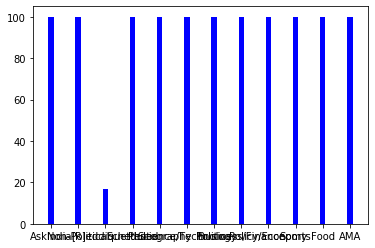

In [33]:
from collections import Counter
import matplotlib.pyplot as plt

counta = Counter(topics_data['flair'])

plt.bar(counta.keys(), counta.values(), 0.2, color='b')


Apart from [R]eddiquette, all other classes are equal.

### Lengths

Now let us see how long each features are. with this we can get an idea of how small/big the feature will be and how it would effect the model

### Body Length

In [24]:
import cufflinks as cf
cf.go_offline()
cf.set_config_file(offline=False, world_readable=True)

length_body = topics_data['body'].astype(str).apply(len)
length_body.iplot(
    kind='hist',
    bins=100,
    xTitle='body length',
    linecolor='black',
    yTitle='count',
    title='Review Text Length Distribution')

### Word count of body

In [25]:
word_count = topics_data['body'].apply(lambda x: len(str(x).split()))
word_count.iplot(
    kind='hist',
    bins=100,
    xTitle='word count',
    linecolor='black',
    yTitle='count',
    title='Review Word Count Distribution')

### Number of comments per post

In [46]:
ncom = topics_data['comms_num']
ncom.iplot(
    kind='hist',
    bins=100,
    xTitle='word count',
    linecolor='black',
    yTitle='count',
    title='number of comments Count Distribution')

### Word count of comments

In [47]:
word_count = topics_data['comments'].apply(lambda x: len(str(x).split()))
word_count.iplot(
    kind='hist',
    bins=100,
    xTitle='word count',
    linecolor='black',
    yTitle='count',
    title='Comments Word Count Distribution')

### Word count of combined feature

In [48]:
word_count = topics_data['feature_combine'].apply(lambda x: len(str(x).split()))
word_count.iplot(
    kind='hist',
    bins=100,
    xTitle='word count',
    linecolor='black',
    yTitle='count',
    title='combined feature Word Count Distribution')

### Word count of title

In [36]:
title_count = topics_data['title'].apply(lambda x: len(str(x).split()))
title_count.iplot(
    kind='hist',
    bins=100,
    xTitle='word count',
    linecolor='black',
    yTitle='count',
    title='Title Word Count Distribution')

### Length of url

In [37]:
length_url = topics_data['url'].astype(str).apply(len)
length_url.iplot(
    kind='hist',
    bins=100,
    xTitle='length',
    linecolor='black',
    yTitle='count',
    title='Review url Length Distribution')

The above plots show that, most posts have a very small number of comments and a small body size. But there are a few anamolies. a few posts have a lot more number of comments or a long body.

Moreover, we can see that title and urls length is relatively much smaller, compact and represents the content. therefore can be a good starting point to begin with.

## Topic 3 - Building a flare detector

In this part a few classifiers are implemented using sklearn. Here are the few classifiers implemented

1) Naive Bayes <br/>
2) SVMs <br/>
3) Logistic Regression <br/>
4) Random Forests <br/>
5) Multi layer perceptron <br/>

Note: RNNs like LSTMs are not used as the trained models of those are large and heavy and is not possible to host in free platforms like Heroku due to size constraints. Moreover, General machine learning algorithms like those implemented here can give reasonable results.

### Naive Bayes

In [ ]:
def nb_classifier(X_train, X_test, y_train, y_test):
  
  from sklearn.naive_bayes import MultinomialNB

  nb = Pipeline([('vect', CountVectorizer()), ('tfidf', TfidfTransformer()), ('clf', MultinomialNB()),])

  nb.fit(X_train, y_train)

  y_pred = nb.predict(X_test)

  print('accuracy %s' % accuracy_score(y_pred, y_test))
  print(classification_report(y_test, y_pred,target_names=flairs))

### SVM

In [ ]:
def linear_svm(X_train, X_test, y_train, y_test):
  
  from sklearn.linear_model import SGDClassifier

  sgd = Pipeline([('vect', CountVectorizer()), ('tfidf', TfidfTransformer()), ('clf', SGDClassifier(loss='hinge', penalty='l2',alpha=1e-3, random_state=42, max_iter=5, tol=None)),])

  sgd.fit(X_train, y_train)

  y_pred = sgd.predict(X_test)

  print('accuracy %s' % accuracy_score(y_pred, y_test))
  print(classification_report(y_test, y_pred,target_names=flairs))

### Logistic Regression

In [ ]:
def logisticreg(X_train, X_test, y_train, y_test):

  from sklearn.linear_model import LogisticRegression

  logreg = Pipeline([('vect', CountVectorizer()), ('tfidf', TfidfTransformer()), ('clf', LogisticRegression(n_jobs=1, C=1e5)), ])
    
  logreg.fit(X_train, y_train)

  y_pred = logreg.predict(X_test)

  print('accuracy %s' % accuracy_score(y_pred, y_test))
  print(classification_report(y_test, y_pred,target_names=flairs))

### Random Forests

In [ ]:
def randomforest(X_train, X_test, y_train, y_test):
  
  from sklearn.ensemble import RandomForestClassifier
  
  ranfor = Pipeline([('vect', CountVectorizer()), ('tfidf', TfidfTransformer()), ('clf', RandomForestClassifier(n_estimators = 1000, random_state = 42)), ])
    
  ranfor.fit(X_train, y_train)

  y_pred = ranfor.predict(X_test)

  print('accuracy %s' % accuracy_score(y_pred, y_test))
  print(classification_report(y_test, y_pred,target_names=flairs))

### Multi Layer Perceptron

In [ ]:
def mlpclassifier(X_train, X_test, y_train, y_test):
  
  from sklearn.neural_network import MLPClassifier
  
  mlp = Pipeline([('vect', CountVectorizer()), ('tfidf', TfidfTransformer()), ('clf', MLPClassifier(hidden_layer_sizes=(30,30,30))), ])
    
  mlp.fit(X_train, y_train)

  y_pred = mlp.predict(X_test)

  print('accuracy %s' % accuracy_score(y_pred, y_test))
  print(classification_report(y_test, y_pred,target_names=flairs))

## Training

The following function is to train the data on different classifiers

In [ ]:
def train_test(X,y):
 
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state = 42)

  print("Results of Naive Bayes Classifier")
  nb_classifier(X_train, X_test, y_train, y_test)
    
  print("Results of Linear Support Vector Machine")
  linear_svm(X_train, X_test, y_train, y_test)
    
  print("Results of Logistic Regression")
  logisticreg(X_train, X_test, y_train, y_test)
    
  print("Results of Random Forest")
  randomforest(X_train, X_test, y_train, y_test)
    
  print("Results of MLP Classifier")
  mlpclassifier(X_train, X_test, y_train, y_test)

## Main 

The following module trains the data using train_test function

First, lets try to use the url as a feature

In [ ]:
X = topics_data.url
Y = topics_data.flair

print("Flair Detection using url as Feature")
train_test(X, Y)

## Accuracy

|Algorithm          |Accuracy|
|-------------------|------|
| Bayes             | 0.32 |
| SVM               | 0.41 |
| Linear Regression | 0.39 |
| Random Forests    | 0.32 |
| MLP               | 0.34 |

The best accuracy here is 0.41 from SVM. Now to try improve the accuracy, let's try to use title as a feature to the various classifiers.

In [ ]:
X = topics_data.title
Y = topics_data.flair

print("Flair Detection using Title as Feature")
train_test(X, Y)

## Accuracy

|Algorithm          |Accuracy|
|-------------------|------|
| Bayes             | 0.62 |
| SVM               | 0.64 |
| Linear Regression | 0.65 |
| Random Forests    | 0.63 |
| MLP               | 0.52 |

The best accuracy here is -------. Now to try improve the accuracy, lets try using the body of the posts for flare detection.

In [ ]:
X = topics_data.body
Y = topics_data.flair

print("Flair Detection using body as Feature")
train_test(X, Y)


## Accuracy

|Algorithm          |Accuracy|
|-------------------|------|
| Bayes             | 0.22 |
| SVM               | 0.26 |
| Linear Regression | 0.28 |
| Random Forests    | 0.31 |
| MLP               | 0.24 |

The best accuracy here is 0.31 with random forests. It performed very poorly than the title as a feature. This might be because the body coudnt be fit in the models we used. Therefore lets not include body as a feature.

In [ ]:
X = topics_data.comments
Y = topics_data.flair

print("Flair Detection using comments as Feature")
train_test(X, Y)

## Accuracy

|Algorithm          |Accuracy|
|-------------------|------|
| Bayes             | 0.57 |
| SVM               | 0.65 |
| Linear Regression | 0.68 |
| Random Forests    | 0.65 |
| MLP               | 0.47 |

The best accuracy here is 0.68 with linear regression. It performed at a par with title. Still, the accuracy is not good enough. So lets try multiple features combined and train on those. 
As body is not giving good accuracy, lets not include it. So lets use title, url and comments as a feature and train on the entworks discussed earlier.

In [ ]:
X = topics_data.feature_combine
Y = topics_data.flair

print("Flair Detection using Title, comments, url as Feature")
train_test(X, Y)

## Accuracy

|Algorithm          |Accuracy|
|-------------------|------|
| Bayes             | 0.62 |
| SVM               | 0.75 |
| Linear Regression | 0.74 |
| Random Forests    | 0.77 |
| MLP               | 0.49 |


The best accuracy is 0.77 with random forests.

We have acheived reasonable accuracy with title, url and comments as the feature.
MLP, naive bayes seems to not working well compared to other algorithms.

These algorithms can only give upto a certain accuracy. If we want to improve accuracy, we might need to use RNNs like LSTM and collect more data. but as those models will be too heavy to be deployed on heroku, we will be using these methods.

Additionally, this model needs to updated regularly to work with current data well. 